In [2]:
# Setup datasets

import mplcursors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from IPython.display import display

# Sources for advanced statistical formulae include:
# https://faq.stathead.com/knowledge/basketball-advanced-stats

# Importing player & team averages/totals datasets
dfs = pd.read_excel(r"BBL Stats & Images/bbl_stats.xlsx", sheet_name = ['player_averages','team_averages','player_totals','team_totals'])

# Merge total and average dataframes. Remove duplicate columns
player_df = pd.merge(dfs['player_averages'], dfs['player_totals'], on='Name').filter(regex='^(?!.*_y)').rename(columns=lambda x: x.replace('_x', ''))
team_df = pd.merge(dfs['team_averages'], dfs['team_totals'], on='Team').filter(regex='^(?!.*_y)').rename(columns=lambda x: x.replace('_x', ''))

# Reformat player names
player_df[['Last Name', 'First Name']] = player_df['Name'].str.split(', ', expand=True)
player_df = player_df.drop(['Name'], axis=1)
player_df['Name'] = player_df['First Name'] + ' ' + player_df['Last Name']
player_df = player_df.drop(['Last Name', 'First Name'], axis=1)
player_df = player_df[['Name'] + [col for col in player_df.columns if col != 'Name']]

# Reformat team names
removed_list = ['B. Braun ', 'Seriös Group ']
for str in removed_list:
    team_df['Team'] = team_df['Team'].str.replace(str, '')

# Add logo/picture references
team_df['path'] = 'BBL Stats & Images/Team Logos/' + team_df['Team'] + '.png'

In [3]:
# Adding additional team statistics

# Est POS (Estimated Possessions) & Est POSPG (Estimated Possessions per Game)
team_df['Est POS'] = (team_df['FGA'] - team_df['OFF']) + team_df['TO'] + (0.4 * team_df['FTA'])
team_df['Est POSPG'] = round(team_df['Est POS']/team_df['GP'], 1)
# OFFRTG (Offensive rating, 100 * points per possession)
team_df['OFFRTG'] = round(100*(team_df['Pts'] / team_df['Est POS']), 1)

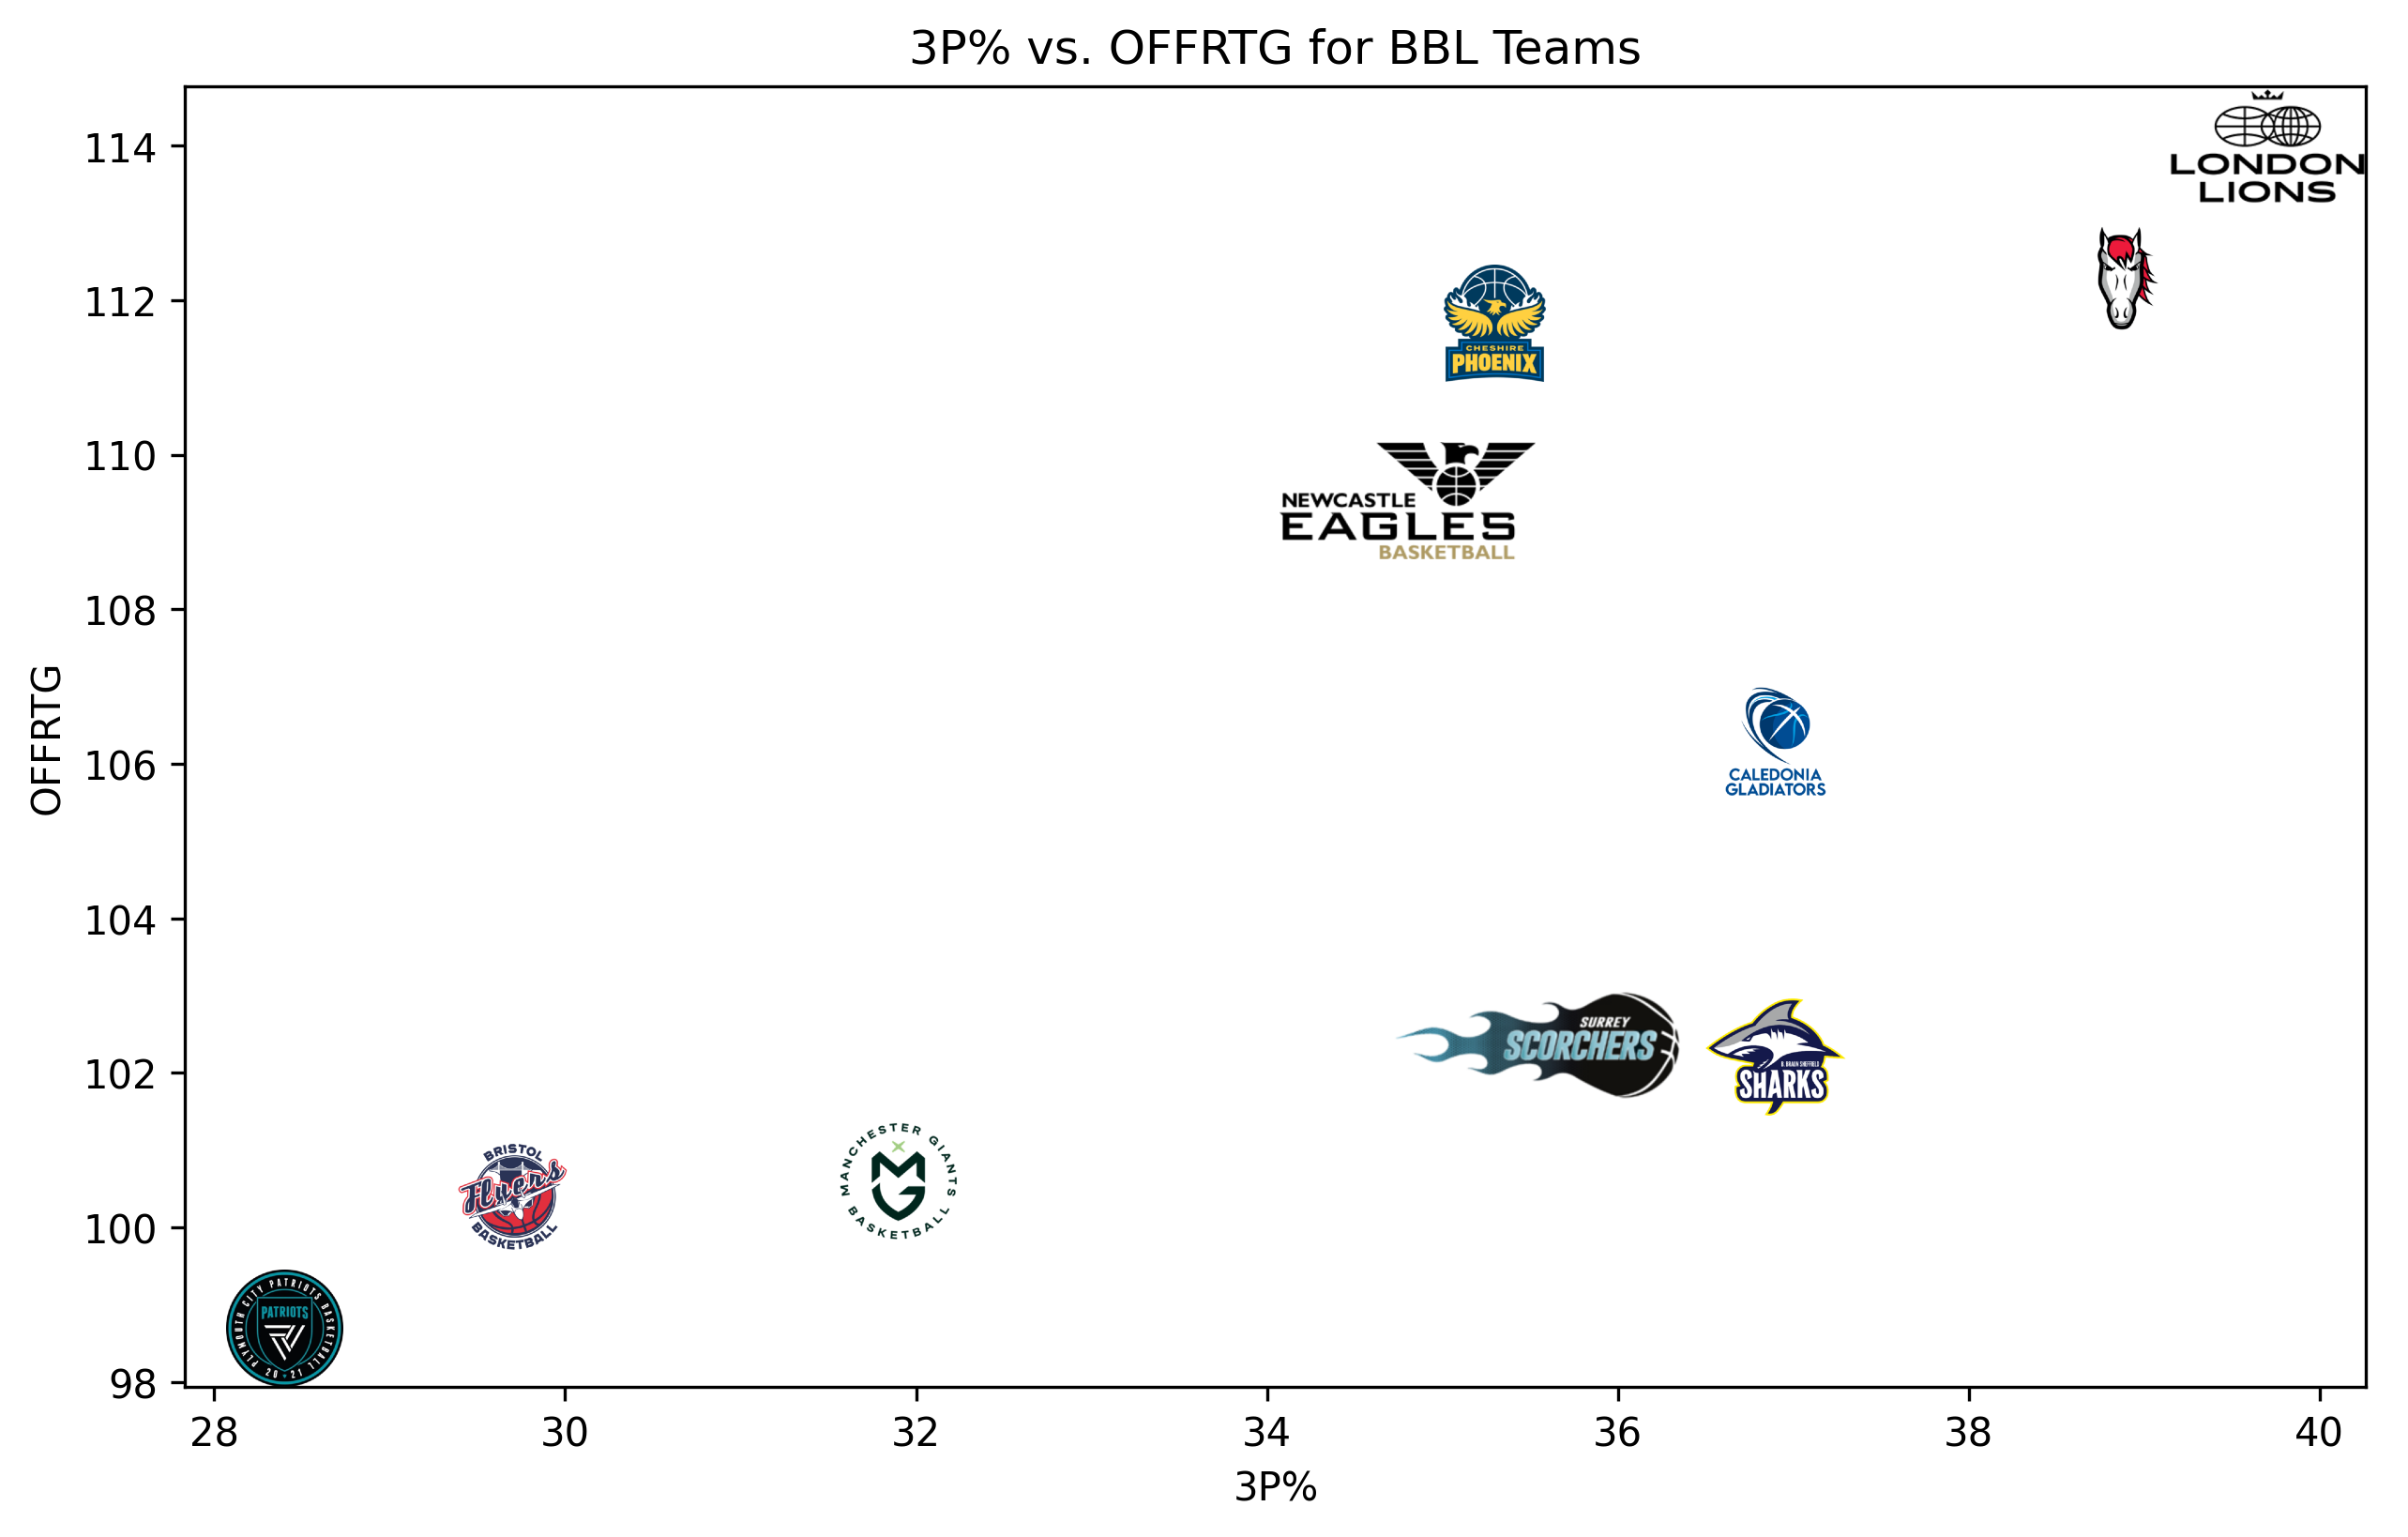

In [4]:
# Visualisations

# Take axis input
# x_axis = input("What do you want plotted on the x-axis?")
# y_axis = input("What do you want plotted on the y-axis?")
x_axis = "3P%"
y_axis = "OFFRTG"

def getImage(path):
    return OffsetImage(plt.imread(path), zoom=0.15, alpha = 1)

fig, ax = plt.subplots(figsize = (10, 6), dpi = 300)
ax.scatter(team_df[x_axis], team_df[y_axis], color = 'white')

for index, row in team_df.iterrows():
    ab = AnnotationBbox(getImage(row['path']), (row[x_axis], row[y_axis]), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel(x_axis)
ax.set_ylabel(y_axis)
ax.set_title(f'{x_axis} vs. {y_axis} for BBL Teams');

In [ ]:
# Adding additional player statistics

# EFG% (Effective Field Goal %)
player_df['eFG%'] = round(100 * (player_df['FGM'] + 0.5 * player_df['3PM']) / player_df['FGA'], 1)
# TS% (True Shooting %)
player_df['TS%'] = round(100 * player_df['PTS'] / (2 * (player_df['FGA'] + .475 * player_df['FTA'])), 1)
# AST:TO
player_df['AST:TO'] = round(player_df['AST']/player_df['TO'], 2)

In [ ]:
# PICK OUT MEMBERS OF 50/40/90 CLUB

fg_condition = player_df['FG%'] >= 50
threepoint_condition = player_df['3P%'] >= 40
ft_condition = player_df['FT%'] >= 90

# The NBA requires at least 300 FGs, 82 3Ps, and 125 FTs made to make the club. This works out to the following per game prerequisites, after adjustment for game length differences.
# Context on some numbers below: 82 is the number of NBA games per season. There are 40 minutes in a BBL game and 48 in an NBA game
fgm_prerequisite = player_df['FGMPG'] >= 300/82 * 40/48
threepointmade_prerequisite = player_df['3PMPG'] >= 82/82 * 40/48
ftm_prerequisite = player_df['FTMPG'] >= 125/82 * 40/48

players_50_40_90 = player_df[fg_condition & threepoint_condition & ft_condition & fgm_prerequisite & threepointmade_prerequisite & ftm_prerequisite]

if players_50_40_90.shape[0] > 0:
    print(f"The 50/40/90 club includes the {players_50_40_90.shape[0]} players below")
    display(players_50_40_90[['Name', 'FG%', '3P%', 'FT%']])
else:
    print("The 50/40/90 club currently includes no players")